In [1]:
# General
import os
import keras
import numpy as np
import pandas as pd
import tensorflow as tf

# Data
import plotly.express as px
import matplotlib.pyplot as plt

# Data Preprocessing
import tensorflow.data as tfds
from sklearn.model_selection import train_test_split

# Model
from keras.applications import VGG16
from keras.applications import Xception, InceptionV3
from keras.applications import ResNet50V2, ResNet152V2
from keras.applications import MobileNetV3Small, MobileNetV3Large

# Model training
from keras import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten, GlobalAveragePooling2D
from keras.layers import InputLayer

# Model Callbacks
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

2024-03-31 19:27:17.647058: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-31 19:27:17.647167: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-31 19:27:17.775044: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Setting constants for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Constants
BATCH_SIZE = 32
IMAGE_SIZE = 224

# Loading & Processing UTK Face **

Total number of images  : 23708
Sample Image path       : 1_0_3_20161220222642427.jpg.chip.jpg
Sample Age              : 1
Sample Gender           : Male



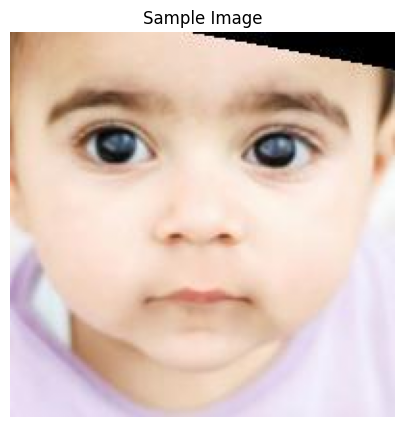

In [3]:
# Initialize the directory path
dir_path = "/kaggle/input/utkface-new/UTKFace/"
image_paths = os.listdir(dir_path)

# Initialize a Gender Mapping
gender_mapping = ["Male", "Female"]

# Choose and load an image randomly
rand_image_path = np.random.choice(image_paths)
rand_image = plt.imread(dir_path + rand_image_path)/255.
sample_age, sample_gender, *_ = rand_image_path.split("_")

print(f"Total number of images  : {len(image_paths)}")
print(f"Sample Image path       : {rand_image_path}")
print(f"Sample Age              : {sample_age}")
print(f"Sample Gender           : {gender_mapping[int(sample_gender)]}\n")

# Show the image
plt.figure(figsize = (5,5))
plt.title("Sample Image")
plt.imshow(rand_image)
plt.axis("off")
plt.show()

In [4]:
# Initialize a male counter variable
male_count = 0

# Initialize variable to store all the ages.
ages = []

# Loop over the paths and check for male images.
for path in image_paths:
    path_split = path.split("_")
    if "0" == path_split[1]:
        male_count += 1
    ages.append(int(path_split[0]))

# Computee total female counts
female_count = len(image_paths) - male_count

# Visualizing The Class Imbalance
pie_chart = px.pie(
    names = gender_mapping,
    values = [male_count, female_count],
    hole = 0.4,
    title = "Gender Distribution (Donut Chart)",
    height = 500
)
pie_chart.show()

bar_graph = px.bar(
    y = gender_mapping,
    x = [male_count, female_count],
    title = "Gender Distribution (Bar Graph)",
    color = gender_mapping,
    height = 500
)
bar_graph.update_layout(
    yaxis_title = "Gender",
    xaxis_title = "Frequency Count"
)
bar_graph.show()

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [5]:
# Histogram
fig = px.histogram(sorted(ages), title = "Age Distribution")
fig.update_layout(
    xaxis_title = "Age",
    yaxis_title = "Value Counts"
)
fig.show()

# Violin Plot
fig = px.violin(x = sorted(ages), title = "Age Distribution")
fig.update_layout(
    xaxis_title = "Age",
    yaxis_title = "Distribution"
)
fig.show()

# Box Plot
fig = px.box(x = sorted(ages), notched=True, title = "Age Distribution")
fig.update_layout(
    xaxis_title = "Age",
)
fig.show()

In [6]:
# SHuffling the Images
np.random.shuffle(image_paths)

# Split data into training, testing and validation set
train_images, test_images = train_test_split(
    image_paths,
    train_size = 0.9,
    test_size = 0.1
)

train_images, valid_images = train_test_split(
    image_paths,
    train_size = 0.9,
    test_size = 0.1
)

print(f"Training Size : {len(train_images)}")
print(f"Testing Size  : {len(test_images)}")

# Extract age and gender
train_ages = [int(path.split("_")[0]) for path in train_images]
train_genders = [int(path.split("_")[1]) for path in train_images]

valid_ages = [int(path.split("_")[0]) for path in valid_images]
valid_genders = [int(path.split("_")[1]) for path in valid_images]

test_ages = [int(path.split("_")[0]) for path in test_images]
test_genders = [int(path.split("_")[1]) for path in test_images]

Training Size : 21337
Testing Size  : 2371


In [7]:
def show_image(image, show=False):
    """
    Displays the provided image without axis.

    Args:
    - image (array-like): The image data to be displayed.
    - show (bool): If True, displays the image immediately. Defaults to False.

    Returns:
    - None
    """
    plt.imshow(image)
    plt.axis("off")

    if show:
        plt.show()


def preprocess_age_data(image_path, age, gender, dir_path=dir_path, IMAGE_SIZE = IMAGE_SIZE):

    # Load the Image
    image = tf.io.read_file(dir_path + image_path)
    image = tf.io.decode_jpeg(image)

    # Resize and Normalize the Image
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = image / 255.
    image = tf.cast(image, tf.float32)

    return image, age

def preprocess_gender_data(image_path, age, gender, dir_path=dir_path, IMAGE_SIZE = IMAGE_SIZE):
 
    # Load the Image
    image = tf.io.read_file(dir_path + image_path)
    image = tf.io.decode_jpeg(image)

    # Resize and Normalize the Image
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = image / 255.
    image = tf.cast(image, tf.float32)

    return image, gender

In [8]:
# Obtain training, testing and validation datasets
train_ds = tfds.Dataset.from_tensor_slices((train_images, train_ages, train_genders)).shuffle(2000)
train_age_ds = train_ds.map(preprocess_age_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)
train_gender_ds = train_ds.map(preprocess_gender_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

valid_ds = tfds.Dataset.from_tensor_slices((valid_images, valid_ages, valid_genders)).shuffle(2000)
valid_age_ds = valid_ds.map(preprocess_age_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)
valid_gender_ds = valid_ds.map(preprocess_gender_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

test_ds  = tfds.Dataset.from_tensor_slices((test_images, test_ages, test_genders)).shuffle(500)
test_age_ds = test_ds.map(preprocess_age_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)
test_gender_ds = test_ds.map(preprocess_gender_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

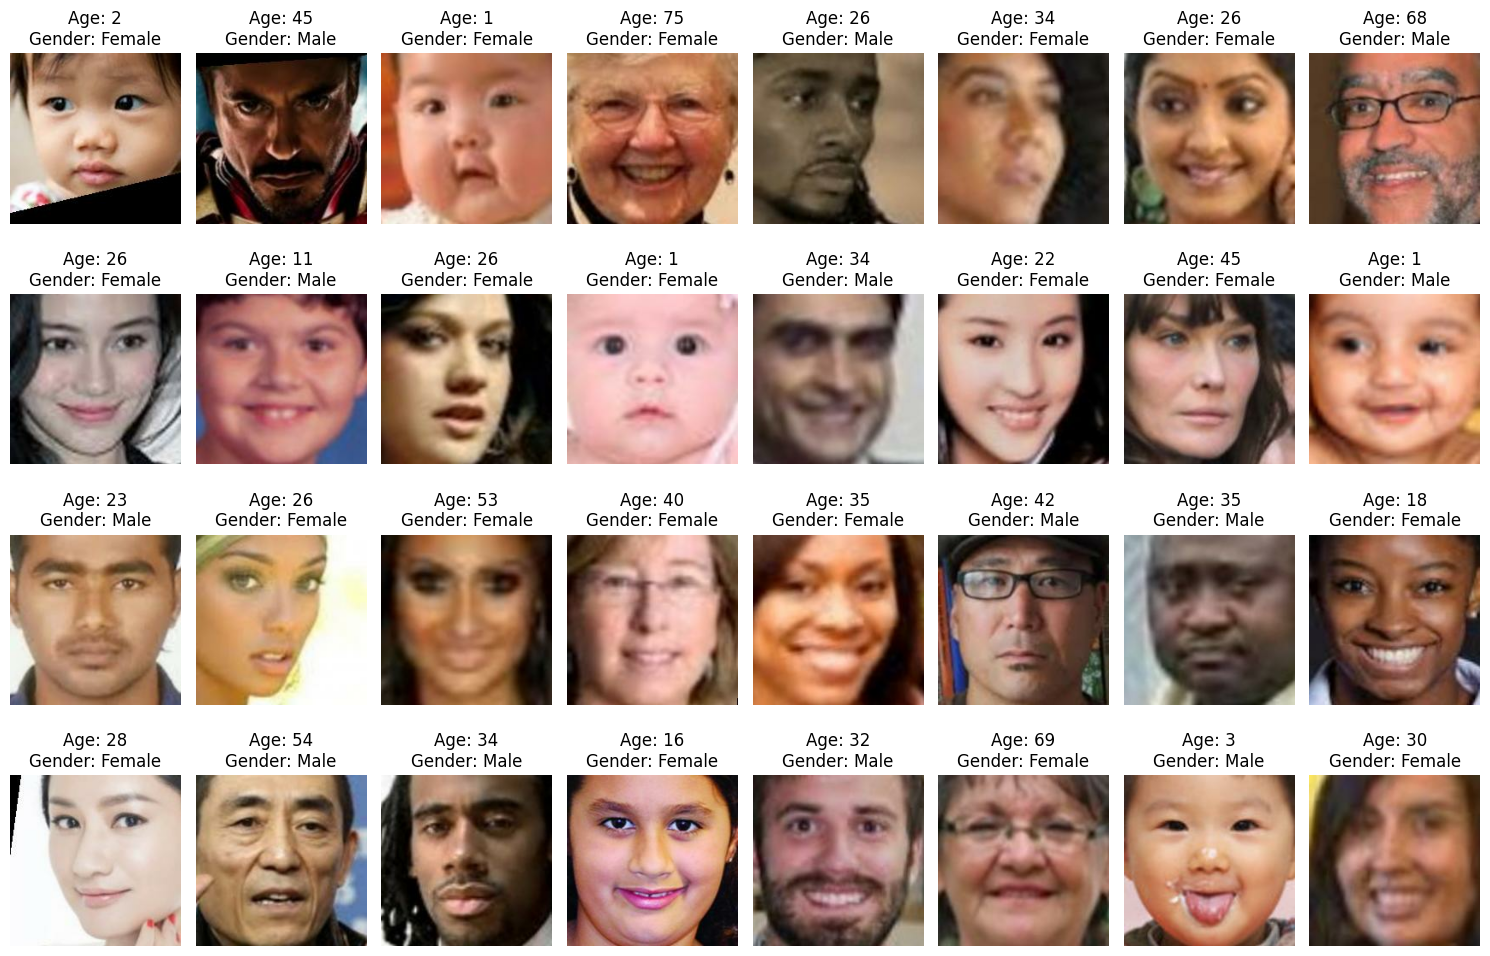

In [9]:
plt.figure(figsize=(15, 10))
for images, ages, genders in train_ds.batch(BATCH_SIZE).take(1):

    for index in range(len(images)):
        image = tf.io.read_file(dir_path + images[index])
        image = tf.io.decode_jpeg(image)
        plt.subplot(4, 8, index + 1)
        plt.imshow(image)
        plt.title(f"Age: {ages[index]}\nGender: {gender_mapping[genders[index]]}")
        plt.axis("off")

plt.tight_layout()
plt.show()

In [10]:
# Initializing the backbone layer
resnet = ResNet152V2(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), include_top = False, weights="imagenet")

# Freeze the backbone weights
resnet.trainable = False

# Creating a gender model
gender_net = Sequential([
    InputLayer((IMAGE_SIZE, IMAGE_SIZE, 3), name="ImageInput"),
    resnet,
    Dropout(0.2, name = "SlightDroput"),
    GlobalAveragePooling2D(name="GlobalAvgPooling"),
    Dense(1, activation="sigmoid", name="gender")
], name="GenderNet")

gender_net.compile(
    loss = "binary_crossentropy",
    optimizer = 'adam',
    metrics = ['accuracy'],
    weighted_metrics=[]
)

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [11]:
# Training the Gender Model
gender_history = gender_net.fit(
    train_gender_ds,
    validation_data = valid_gender_ds,
    epochs = 20,
    batch_size = BATCH_SIZE,
    callbacks = [
        EarlyStopping(
            patience = 5,
            monitor = "val_accuracy",
            restore_best_weights = True
        ),

        ModelCheckpoint(
            "Gender-ResNet152.keras",
            save_best_only=True
        )
    ]
)

Epoch 1/20
  1/667 ━━━━━━━━━━━━━━━━━━━━ 5:56:08 32s/step - accuracy: 0.5000 - loss: 0.7828

I0000 00:00:1711913296.570061      87 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


667/667 ━━━━━━━━━━━━━━━━━━━━ 139s 161ms/step - accuracy: 0.7893 - loss: 0.4392 - val_accuracy: 0.8524 - val_loss: 0.3375
Epoch 2/20
667/667 ━━━━━━━━━━━━━━━━━━━━ 78s 118ms/step - accuracy: 0.8558 - loss: 0.3324 - val_accuracy: 0.8524 - val_loss: 0.3273
Epoch 3/20
667/667 ━━━━━━━━━━━━━━━━━━━━ 79s 118ms/step - accuracy: 0.8617 - loss: 0.3172 - val_accuracy: 0.8659 - val_loss: 0.3014
Epoch 4/20
667/667 ━━━━━━━━━━━━━━━━━━━━ 78s 117ms/step - accuracy: 0.8697 - loss: 0.3023 - val_accuracy: 0.8650 - val_loss: 0.2965
Epoch 5/20
667/667 ━━━━━━━━━━━━━━━━━━━━ 78s 117ms/step - accuracy: 0.8732 - loss: 0.2957 - val_accuracy: 0.8705 - val_loss: 0.2947
Epoch 6/20
667/667 ━━━━━━━━━━━━━━━━━━━━ 78s 117ms/step - accuracy: 0.8772 - loss: 0.2930 - val_accuracy: 0.8663 - val_loss: 0.2945
Epoch 7/20
667/667 ━━━━━━━━━━━━━━━━━━━━ 76s 114ms/step - accuracy: 0.8776 - loss: 0.2873 - val_accuracy: 0.8650 - val_loss: 0.2992
Epoch 8/20
667/667 ━━━━━━━━━━━━━━━━━━━━ 78s 117ms/step - accuracy: 0.8844 - loss: 0.2795 - va

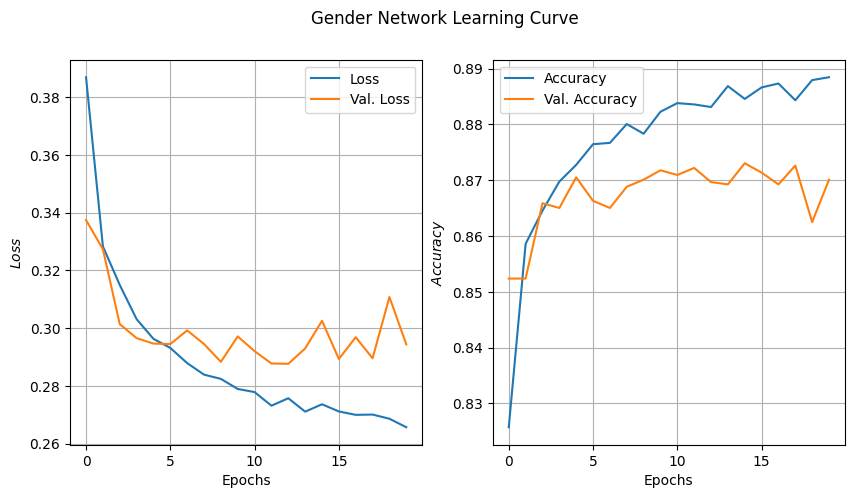

In [12]:
# Converting history into data frame.
gender_his_df = pd.DataFrame(gender_history.history)

# Visualization
plt.figure(figsize=(10, 5 ))
plt.subplot(1,2,1)
plt.suptitle("Gender Network Learning Curve")
plt.plot(gender_his_df['loss'], label="Loss")
plt.plot(gender_his_df['val_loss'], label="Val. Loss")
plt.xlabel("Epochs")
plt.ylabel("$Loss$")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(gender_his_df['accuracy'], label="Accuracy")
plt.plot(gender_his_df['val_accuracy'], label="Val. Accuracy")
plt.xlabel("Epochs")
plt.ylabel("$Accuracy$")
plt.grid()
plt.legend()

plt.show()